In [1]:
#========================================================================
# Copyright 2019 Science Technology Facilities Council
# Copyright 2019 University of Manchester
#
# This work is part of the Core Imaging Library developed by Science Technology	
# Facilities Council and University of Manchester
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0.txt
# 
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# 
#=========================================================================

## Tikhonov regularisation using CGLS and block framework

This exercise introduces Tikhonov regularisation and explains how this is implemented in the CIL framework using the so-called block framework.

In a previous exercise, it was seen how CGLS could be used to determine a reconstruction based on the least squares reconstruction problem. It was seen that in case of noisy data, the least squares solution obtained by running until convergence is not desirable due to a high amount of noise. The number of iterations was seen to have a regularising effect, with the smooth, low-frequency components of the image recovered in the first iterations, while high-frequency components of the image such as edges were recovered later. Unfortunately, noise also kicks in, and one needs to pick the number of iterations that best balances the sharpness and amount of noise. As such, the regularising effect is implicitly obtained by choosing the number of iterations to run and never actually running until converged to the least squares solution.

Tikhonov regularisation is more explicit in that a regularisation term is added to the least squares fitting term, specifically a squared 2-norm. This problem should now be solved to convergence instead of using the number of iterations as implicit regularising effect. Instead, a parameter, the regularisation parameter, balances the emphasis on fitting the data and enforcing the regularity and must be chosen to provide the best trade-off.

Tikhonov regularisation tends to offer reduction of noise in the reconstruction, at the price of some blurring. This will be seen in what follows.

To set up Tikhonov problems we need to represent block matrices and concatenate data. In CIL we can do this using BlockOperator and BlockDataContainer as demonstrated in the exercise.

**Learning objectives:**
1. Construct and manipulate BlockOperators and BlockDataContainer, including direct and adjoint operations and algebra.
2. Use Block Framework to solve Tikhonov regularisation with CGLS algorithm.
3. Apply Tikhonov regularisation to tomographic reconstruction and explain the effect of regularisation parameter and operator in regulariser.

First, all imports required are carried out. This includes tools from the ccpi.framework and ccpi.optimisation modules, as well as test image generation tools in the tomophantom library and standard imports such as numpy.

In [2]:
# CIL core components needed
from cil.framework import ImageGeometry, ImageData, AcquisitionGeometry, AcquisitionData, BlockDataContainer

# CIL optimisation algorithms and linear operators
from cil.optimisation.algorithms import CGLS
from cil.optimisation.operators import BlockOperator, GradientOperator, IdentityOperator, FiniteDifferenceOperator

# CIL example synthetic test image
from cil.utilities.dataexample import SHAPES

# CIL display tools
from cil.utilities.display import show2D, show_geometry

# Forward/backprojector from CIL ASTRA plugin
from cil.plugins.astra import ProjectionOperator

# For shepp-logan test image in CIL tomophantom plugin
import cil.plugins.TomoPhantom as TP

#import tomophantom
#from tomophantom import TomoP2D
#import scipy

# Third-party imports
import numpy as np    
import matplotlib.pyplot as plt
import os

### Setting up a simulated 2D dataset

A 2D parallel beam case will be simulated. We start by creating a test image and will use the classic Shepp-Logan Phantom with 1024x1024 pixels on the square domain [-1,1]x[-1,1]. We set up the `ImageGeometry` to specify the dimensions and pixel size of the image:

In [3]:
# Set up image geometry
n = 256
ig = ImageGeometry(voxel_num_x=n, 
                   voxel_num_y=n, 
                   voxel_size_x=2/n, 
                   voxel_size_y=2/n)
print(ig)

Number of channels: 1
channel_spacing: 1.0
voxel_num : x256,y256
voxel_size : x0.0078125,y0.0078125
center : x0,y0



Using the CIL tomophantom plugin we can create a CIL ImageData holding the Shepp-Logan image of the desired size:

In [4]:
phantom2D = TP.get_ImageData(num_model=1, geometry=ig)

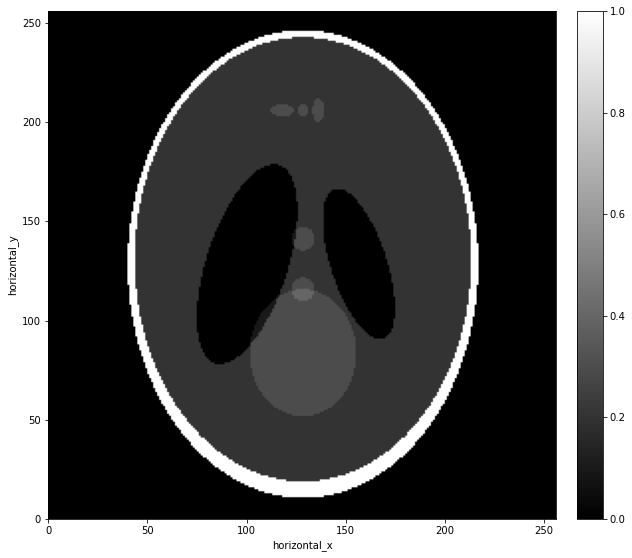

In [5]:
show2D(phantom2D)

Next, we specify the acquisition parameters and store them in an `AcquisitionGeometry` object. We use a parallel-beam geometry with 180 projections, a detector the same of number and size of pixels as the image:

In [6]:
num_angles = 180
ag = AcquisitionGeometry.create_Parallel2D()  \
                   .set_angles(np.linspace(0, 180, num_angles, endpoint=False))  \
                   .set_panel(n, 2/n)
print(ag)

2D Parallel-beam tomography
System configuration:
	Ray direction: [0., 1.]
	Rotation axis position: [0., 0.]
	Detector position: [0., 0.]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [256, 1]
	Pixel size: [0.0078125, 0.0078125]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 180
	Angles 0-20 in degrees:
[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
 15., 16., 17., 18., 19.]



We illustrate the geometry:

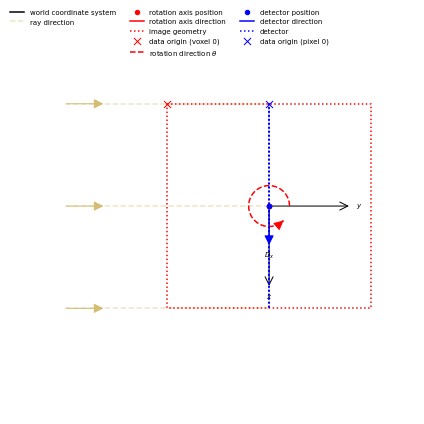

In [7]:
show_geometry(ag)

To simulate a sinogram we set up a ProjectionOperator using GPU-acceleration using the ASTRA plugin:

In [8]:
device = "gpu"
A = ProjectionOperator(ig, ag, device)

The ideal noisefree sinogram is created by forward-projecting the phantom:

In [9]:
sinogram = A.direct(phantom2D)

The generated test image and sinogram are displayed as images:

/opt/anaconda3/envs/ciljj21dev/lib/python3.7/site-packages/cil/utilities/display.py:309: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


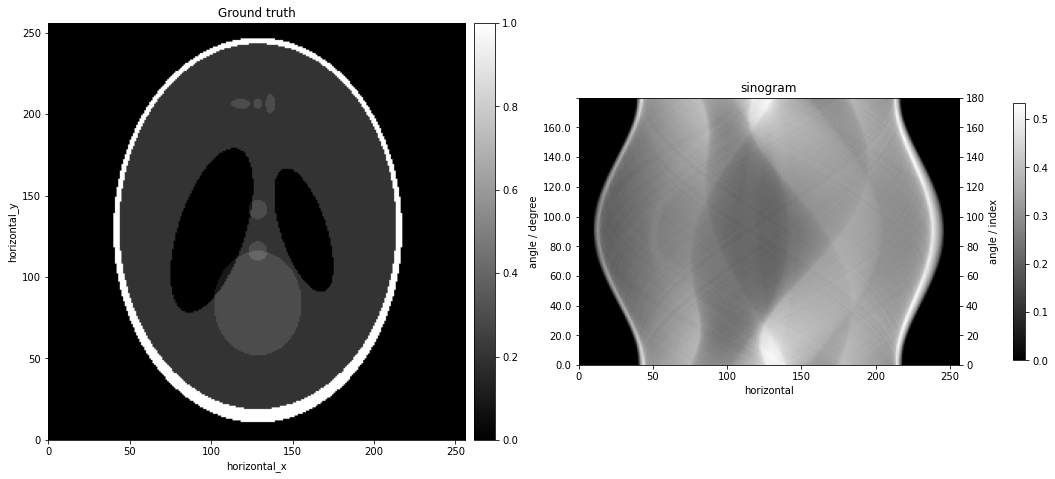

In [10]:
plots = [phantom2D, sinogram]
titles = ["Ground truth", "sinogram"]
show2D(plots, titles)

<a id="section_noise"></a>
Next, Poisson noise will be applied to this noise-free sinogram. The severity of the noise can be adjusted by changing the background_counts variable. 

In [11]:
# Incident intensity: lower counts will increase the noise
background_counts = 5000 

# Convert the simulated absorption sinogram to transmission values using Lambert-Beer. 
# Use as mean for Poisson data generation.
# Convert back to absorption sinogram.
counts = background_counts * np.exp(-sinogram.as_array())
noisy_counts = np.random.poisson(counts)
sino_out = -np.log(noisy_counts/background_counts)

# Create new AcquisitionData object with same geometry and fill with noisy data.
sinogram_noisy = ag.allocate()
sinogram_noisy.fill(sino_out)

The simulated clean and noisy sinograms are displayed side by side as images:

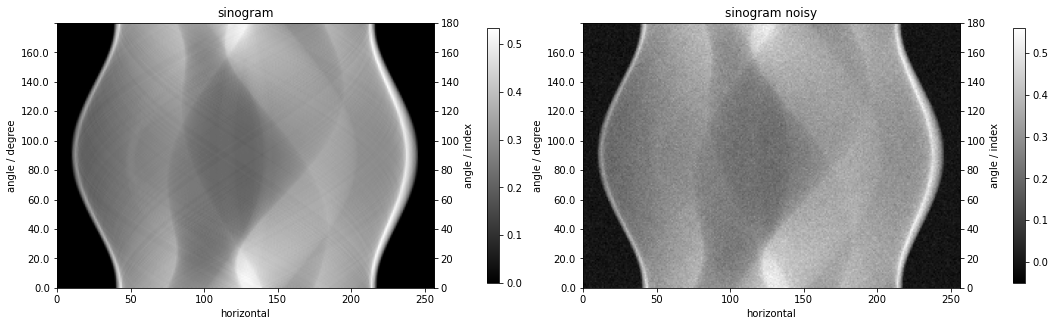

In [12]:
plots = [sinogram, sinogram_noisy]
titles = ["sinogram", "sinogram noisy"]
show2D(plots, titles)

<a id="section_CGLS_simple"></a>
### Reconstruct using CGLS

Before describing Tikhonov regularisation, we recall the problem solved by CGLS:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b\end{Vmatrix}^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the unknown image to be determined

In the solution provided by CGLS the low frequency components tend to converge faster than the high frequency components. This means we need to control the number of iterations carefully to select the optimal solution.

Set up the CGLS algorithm, including specifying its initial point to start from, and an upper bound on the number of iterations to run:

In [13]:
x_init = ig.allocate(0)
cgls_simple = CGLS(x_init=x_init, operator=A, data=sinogram_noisy)
cgls_simple.max_iteration = 1000

CGLS setting up
CGLS configured


Once set up, we can run the algorithm for a specified number of iterations:

In [14]:
cgls_simple.run(5, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.66408e+03
        1       1000         0.036          3.50550e+02
        2       1000         0.032          1.31470e+02
        3       1000         0.030          7.27386e+01
        4       1000         0.029          4.45797e+01
        5       1000         0.036          2.49759e+01
-------------------------------------------------------
        5       1000         0.036          2.49759e+01
Stop criterion has been reached.



Display the resulting image from CGLS, along with its difference image with the original ground truth image:

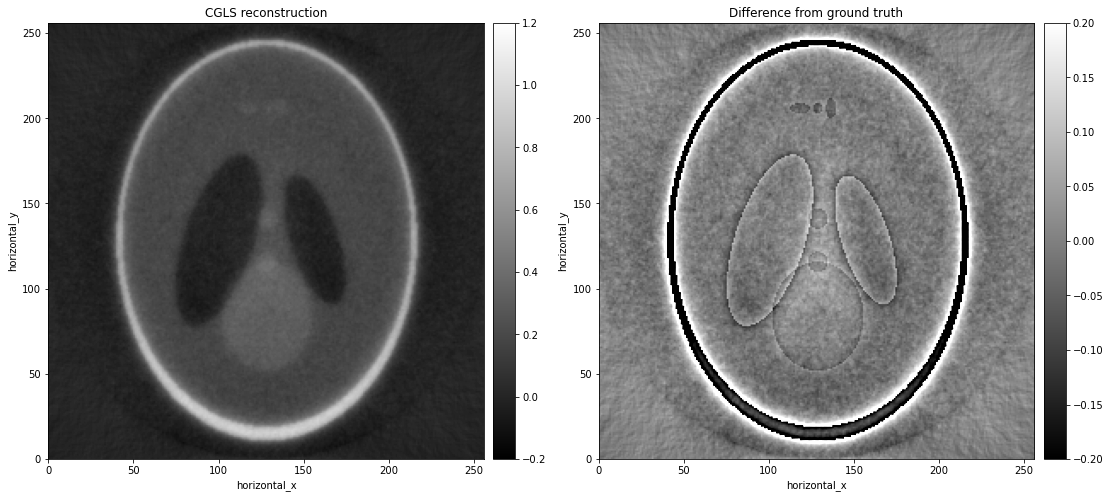

In [15]:
plots = [cgls_simple.solution, cgls_simple.solution - phantom2D]
titles = ["CGLS reconstruction","Difference from ground truth" ]
show2D(plots, titles, fix_range=[(-0.2,1.2),(-0.2,0.2)])

Plot central vertical line profile of CGLS and ground truth:

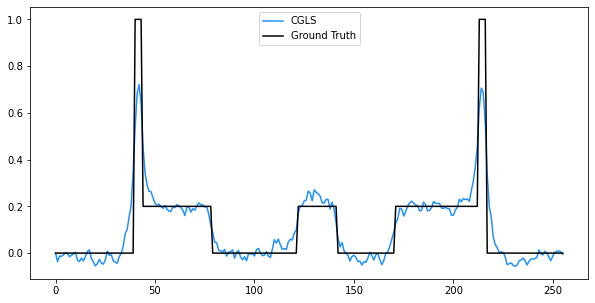

In [16]:
plt.figure(figsize=(10,5))
plt.plot(cgls_simple.solution.get_slice(horizontal_y=n/2).as_array(),label="CGLS",color='dodgerblue')
plt.plot(phantom2D.get_slice(horizontal_y=n/2).as_array(),label="Ground Truth",color='black')
plt.legend()
plt.show()

<span style="color:red;font-size:larger">**Exercise 1:**</span> Try running fewer and more iterations to see how the image and line profile changes. Try also with noisier data, by specifying a smaller value of background_counts. Remember you can change the number of iterations to run between outputs. Also note that the algorithm will continue from the point it stopped and run more iterations from that point if `run` is called again. If you want to run from the beginning, the algorithm needs to be re-initialised. Try to stop the algorithm before the solution starts to diverge. [go to section start](#section_CGLS_simple)

### Tikhonov regularisation using CGLS

#### Regularisation

Noisy datasets are problematic with an ill-posed problem such as tomographic reconstruction. If we try to solve these using CGLS we end up with an unstable solution. Regularisation adds information in order for us to solve the problem.

#### Tikhonov regularisation

We can add a regularisation term to problem solved by CGLS; this gives us the minimisation problem in the following form, which is known as Tikhonov regularisation:
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}A u - b \end{Vmatrix}^2_2 + \alpha^2\|Lu\|^2_2$$

where,

- $A$ is the projection operator

- $b$ is the acquired data

- $u$ is the unknown image to be solved for

- $\alpha$ is the regularisation parameter

- $L$ is a regularisation operator


The first term measures the fidelity of the solution to the data. The second term meausures the fidelity to the prior knowledge we have imposed on the system, operator $L$. $\alpha$ controls the trade-off between these terms. $L$ is often chosen to be a smoothing operator like the identity matrix, or a gradient operator **constrained to the squared L2-norm**.

This can be re-written equivalently in the block matrix form:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\binom{A}{\alpha L} u - \binom{b}{0}\end{Vmatrix}^2_2$$

With the definitions:

- $\tilde{A} = \binom{A}{\alpha L}$

- $\tilde{b} = \binom{b}{0}$

this can now be recognised as a least squares problem:

$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$

and being a least squares problem, it can be solved using CGLS with $\tilde{A}$ as operator and $\tilde{b}$ as data.


#### Introducing the block framework

We can construct $\tilde{A}$ and $\tilde{b}$ using the BlockFramework in the CIL.

$\tilde{A}$ is a (column) BlockOperator of size 2x1 and can be set up by

`BlockOperator(op0,op1)`

The right hand side $\tilde{b}$ is a BlockDataContainer and can be set up by

`BlockDataContainer(DataContainer0, DataContainer1)`

<a id="section_CGLS_alpha"></a>
#### Reconstruct using CGLS and the identity operator

The simplest form of Tikhonov uses the identity matrix as the regularisation operator. We use an identity matrix as our regularisation operator we are penalising on the magnitude of the solution $u$, which will tend to reduce the pixel values of $u$.

In [17]:
L = IdentityOperator(ig)
alpha = 0.1

operator_block = BlockOperator(A, alpha*L)

In the formulation of Tikhonov as a least squares problem, we need to set up the right hand side vector $\tilde{b}$ holding both the $b$ and a zero-filled `ImageData` of the right size, matching the range of the regularising operator. The operator allows us to query the geometry of its range and allocate a zero-filled `ImageData` of that geometry. We combine both into a `BlockDataContainer`:

In [18]:
zero_data = L.range.allocate(0)

data_block = BlockDataContainer(sinogram_noisy, zero_data)

Run CGLS as before, but passing the BlockOperator and BlockDataContainer

In [19]:
#setup CGLS with the Block Operator and Block DataContainer
x_init = ig.allocate(0)      
cgls_tikh = CGLS(x_init=x_init, operator=operator_block, data=data_block, update_objective_interval = 10)
cgls_tikh.max_iteration = 1000

CGLS setting up
CGLS configured


In [20]:
#run the algorithm
cgls_tikh.run(100)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.66408e+03
       10       1000         0.026          4.35837e+01
       20       1000         0.027          4.25749e+01
       30       1000         0.028          4.25441e+01
       40       1000         0.029          4.25429e+01
       50       1000         0.029          4.25428e+01
       54       1000         0.029                     
Tolerance is reached: 1e-06
-------------------------------------------------------
       54       1000         0.029                     
Stop criterion has been reached.



Display results as images and plot central vertical line profile of the Tikhonov with Identity:

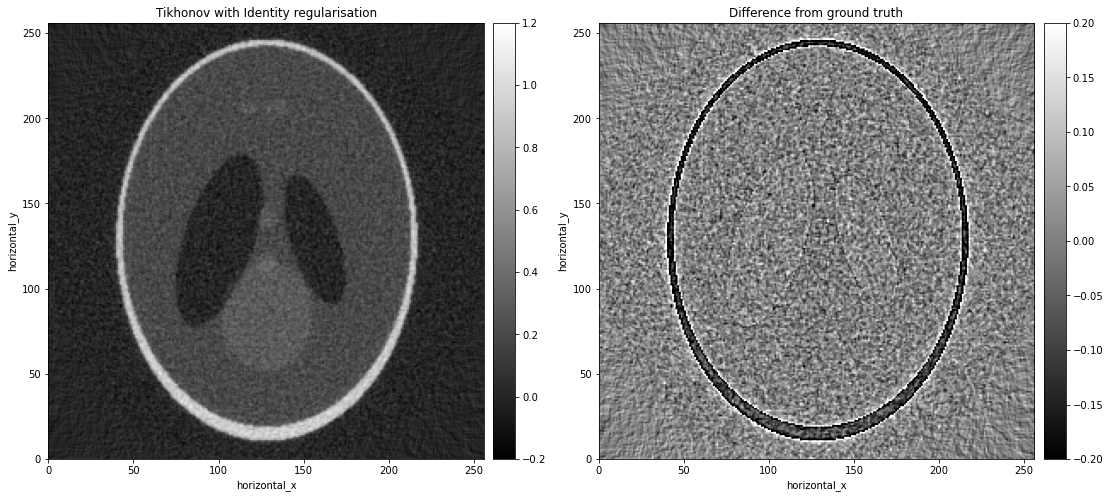

In [21]:
plots = [cgls_tikh.solution, cgls_tikh.solution - phantom2D]
titles = ["Tikhonov with Identity regularisation","Difference from ground truth" ]
show2D(plots, titles, fix_range=[(-0.2,1.2),(-0.2,0.2)])

Let's compare the reconstructions from CGLS and Tikhonov with identity regularisation.

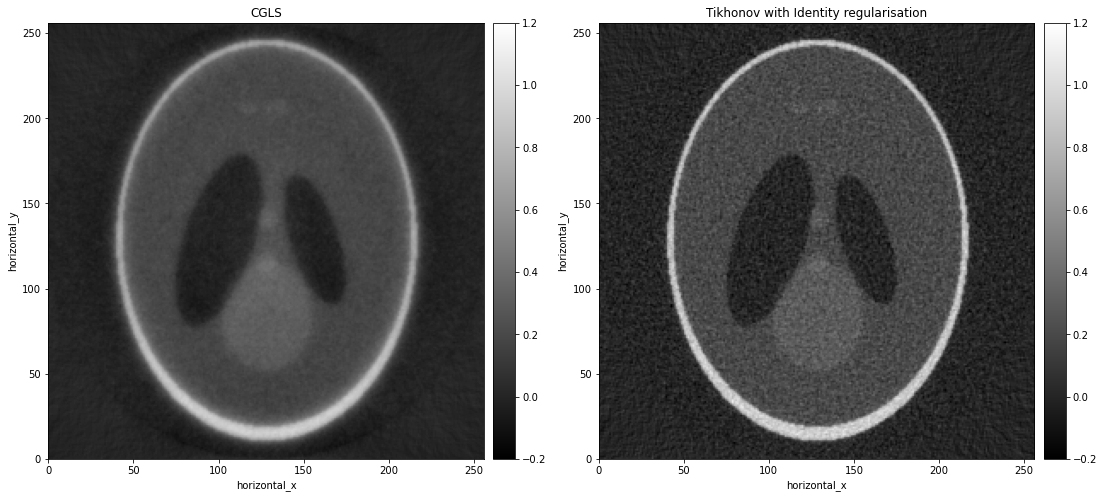

In [22]:
plots = [cgls_simple.solution, cgls_tikh.solution]
titles = ["CGLS", "Tikhonov with Identity regularisation" ]
show2D(plots, titles, fix_range=(-0.2,1.2))

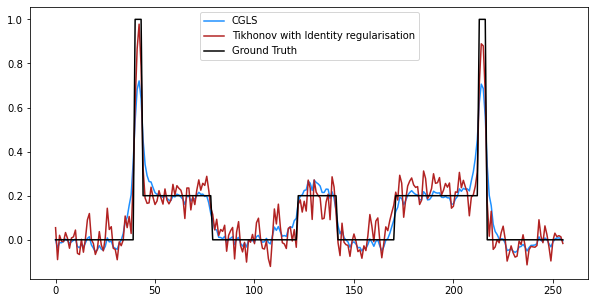

In [23]:
#compare the vertical line profiles
plt.figure(figsize=(10,5))
plt.plot(cgls_simple.solution.get_slice(horizontal_y=n/2).as_array(),label="CGLS",color='dodgerblue')
plt.plot(cgls_tikh.solution.get_slice(horizontal_y=n/2).as_array(),label="Tikhonov with Identity regularisation",color='firebrick')
plt.plot(phantom2D.get_slice(horizontal_y=n/2).as_array(),label="Ground Truth",color='black')
plt.legend()
plt.show()

<span style="color:red;font-size:larger">**Exercise 2:**</span> Try running Tikhonov with a range of $\alpha$ values from very small to very large, display reconstruction and line profile and describe the effect of $\alpha$. Find the value of $\alpha$ that gives you the best solution. Then change how much noise you add to the data by going back here: [set noise](#section_noise) and run through the notebook again. Try with `background_counts` set to 5000, 10000 and 1000 remember to find an appropriate value of alpha for each run.

With Tikhonov regularisation the problem should now be solved to convergence instead of using the number of iterations as implicit regularising effect. By increasing the regularisation parameter $\alpha$ we balances the emphasis on fitting the data and enforcing the regularity. A low value of $\alpha$ will give you the CGLS solution, a higher value will reduce the noise in the reconstruction but at the cost of some blurring.



### Using the BlockFramework to build a gradient operator

The basic Tikhonov with the identity operator provided perhaps a bit of improvement compared to just CGLS, but there was still a lot of noise in the reconstruction and the pixel values had been reduced. Using the identity as regularising operator means that we penalise pixel values that are non-zero, which may not be what we want. Instead, we want to encourage similar values of neighboring pixels to smooth out the noise. This can be achieved by using the gradient as the smoothing operator. 

To do that we will again need to use the BlockFramework, which is now demonstrated in a bit more detail.

A discrete gradient operator (using finite differences) can be constructed using BlockOperators.

The direct gradient operator $\nabla$ acts on an image $u$ and returns a BlockDataContainer $\textbf{w}$, holding finite differences in the $x$ and $y$ directions:

$$ \nabla(u) = 
\begin{bmatrix}
   \nabla_x\\
   \nabla_y\\
\end{bmatrix}
*u =
\begin{bmatrix}
    \nabla_xu\\
    \nabla_yu\\
\end{bmatrix}
=  
\begin{bmatrix}w_{x}\\w_{y}\end{bmatrix}= \textbf{w}$$

The adjoint gradient operator $\nabla^*$ acts on the BlockDataContainer $\textbf{y}$ and returns an image $\rho$

$$  \nabla^*(\textbf w) = 
\begin{bmatrix}
    \nabla^*_x &
    \nabla^*_y
\end{bmatrix}
*
\begin{bmatrix}
    w_{x}\\
    w_{y}\\
\end{bmatrix} 
=
\begin{bmatrix}
    \nabla^*_x w_x + \nabla^*_y w_y
\end{bmatrix} =  \rho$$

We load a test image to demonstrate how the gradient operator works:

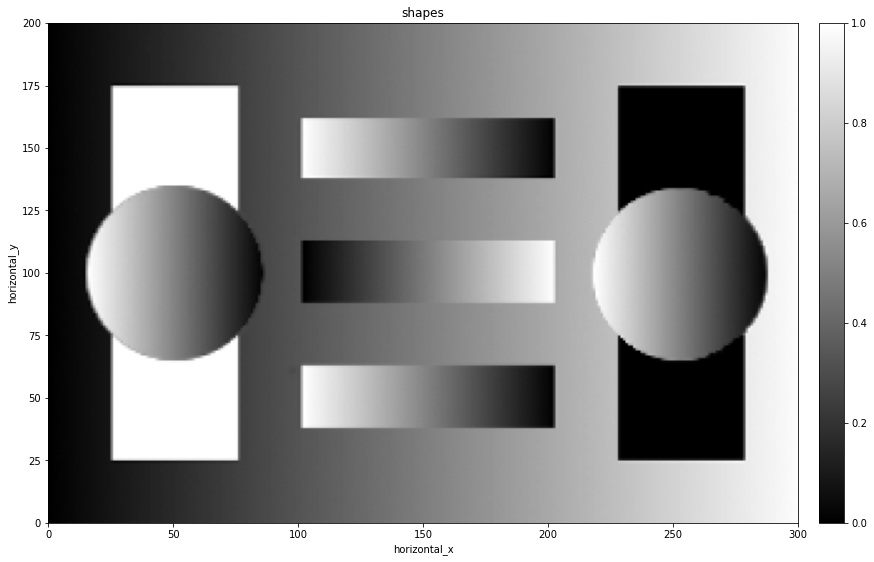

In [24]:
shapes = SHAPES.get()
show2D(shapes, "shapes")

The finite difference operator can be called from the framework. This returns the difference between each pair of pixels along one direction.

We need to initialise it with the image geometry, the direction of the calculation and the boundary conditions to use.

`FiniteDifferenceOperator(gm_domain, direction, bnd_cond='Neumann' or 'Periodic')`

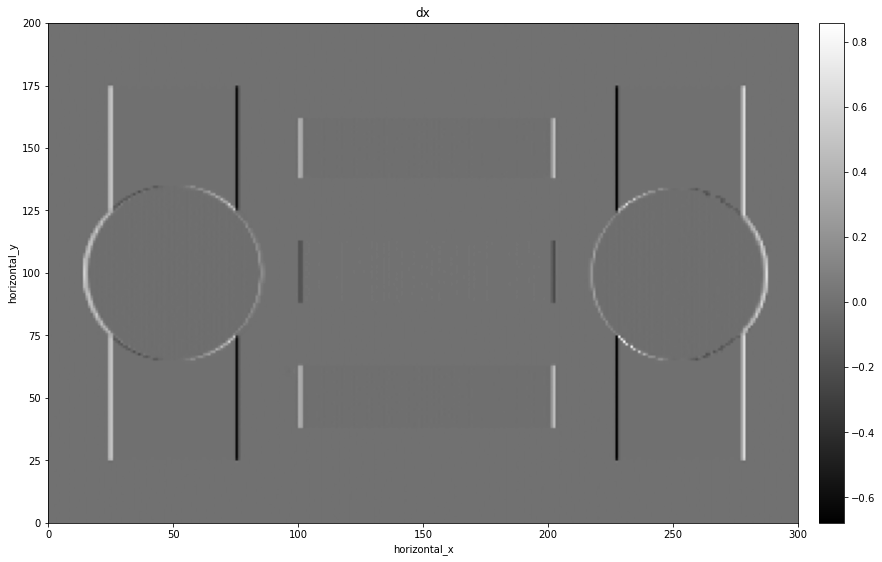

In [25]:
#define the operator FiniteDiff - needs to image geometry, the direction and the boundary conditions
fdx = FiniteDifferenceOperator(shapes.geometry, direction='horizontal_x', bnd_cond='Neumann')

#run it over the input image
image_2D_dx = fdx.direct(shapes)

#plot ths results
show2D(image_2D_dx, "dx")

Note how all vertical edges have been picked up (and their sign) applying this operator doing finite differences in the horizontal direction.

To set up a gradient in both $x$ and $y$ directions, we can create a BlockOperator to containing a finite difference operator for each of the $x$ and $y$ directions. We can apply it (using its `direct` method) to the test image and visualise the result.

In [26]:
# Define the x and y operators 
fdx = FiniteDifferenceOperator(shapes.geometry, direction='horizontal_x', bnd_cond='Neumann')
fdy = FiniteDifferenceOperator(shapes.geometry, direction='horizontal_y', bnd_cond='Neumann')

In [27]:
# Construct the BlockOperator combining the two operators
FD = BlockOperator(fdx, fdy)

In [28]:
#run it on the test image
fd_out = FD.direct(shapes)

Display output:

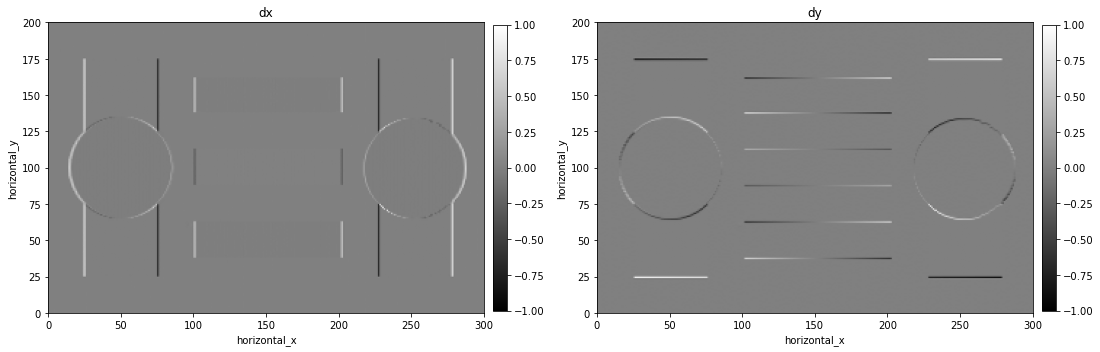

In [29]:
plots = [fd_out.get_item(0), fd_out.get_item(1)]
titles = ["dx","dy" ]
show2D(plots,titles,fix_range=(-1,1))

To see what is going on, we take a closer look at data types.

First, the input is an `ImageData` and its shape is a 2-element vector with the number of pixels in each direction:

In [30]:
print(type(shapes))
print(shapes)

<class 'cil.framework.framework.ImageData'>
Number of dimensions: 2
Shape: (200, 300)
Axis labels: ('horizontal_y', 'horizontal_x')



The output however is a `BlockDataContainer`, essentially a list (with additional functionality) holding two `ImageData` elements, one for each direction we have taken finite differences. We can pick out each element of the `BlockDataContainer` and see that they indeed are `ImageData` and print their shapes (number of pixels in each direction):

In [31]:
#output is BloackDataContainer
print(type(fd_out))
print(fd_out.shape)

<class 'cil.framework.BlockDataContainer.BlockDataContainer'>
(2, 1)


In [32]:
print("\tDataContainer 0")
print(type(fd_out.get_item(0)))
print(fd_out.get_item(0))

	DataContainer 0
<class 'cil.framework.framework.ImageData'>
Number of dimensions: 2
Shape: (200, 300)
Axis labels: ('horizontal_y', 'horizontal_x')



In [33]:
print("\tDataContainer 1")
print(type(fd_out.get_item(1)))
print(fd_out.get_item(1))

	DataContainer 1
<class 'cil.framework.framework.ImageData'>
Number of dimensions: 2
Shape: (200, 300)
Axis labels: ('horizontal_y', 'horizontal_x')



The BlockFramework provides basic algebra between BlockDataContainers, numpy arrays, lists of numbers,  DataContainers, subclasses and scalars providing the shape of the containers are compatible
- add
- subtract
- multiply
- divide
- power
- squared_norm

The `BlockOperator` is a special kind of `Operator`, and being an `Operator` it should have an adjoint method. This is automatically provided from the ajoints of the operators. In the present case our `BlockOperator` will take a `BlockDataContainer` as input to its adjoint and return an `ImageData`, as visualised below:


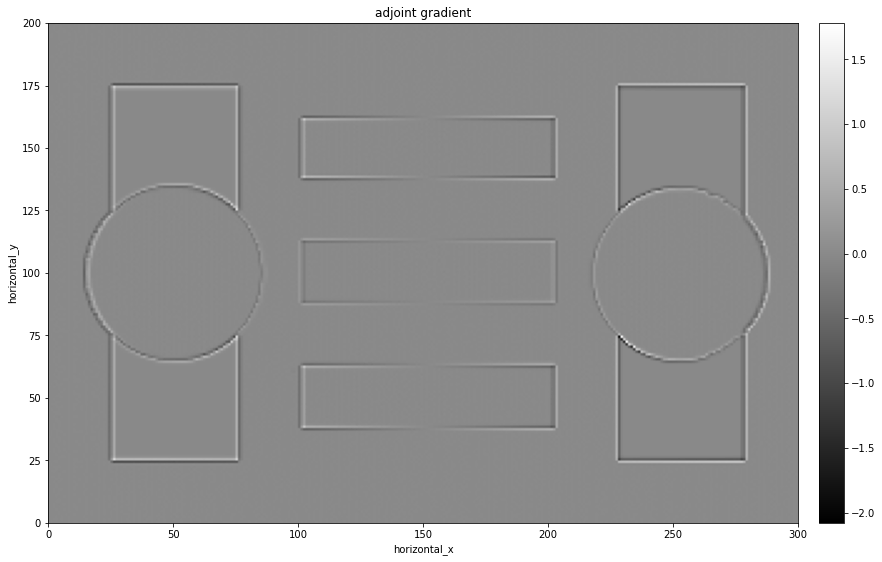

In [34]:
# Run the adjoint method
adjoint_output = FD.adjoint(fd_out)

show2D(adjoint_output, "adjoint gradient")

### A deeper look at the BlockFramework
#### BlockDataContainer 

BlockDataContainer holds datacontainers as a column vector

$$\textbf{x} = \begin{bmatrix}x_{1}\\ x_{2}\end{bmatrix}$$

$$\textbf{y} = \begin{bmatrix}y_{1}\\ y_{2} \\ y_{3}\end{bmatrix}$$

#### BlockOperator: 

BlockOperator is a matrix of operators.

$$ K = \begin{bmatrix}
A_{1} & A_{2} \\
A_{3} & A_{4} \\
A_{5} & A_{6}
\end{bmatrix}_{(3,2)} *  \quad \underbrace{\begin{bmatrix}
x_{1} \\
x_{2} 
\end{bmatrix}_{(2,1)}}_{\textbf{x}} =  \begin{bmatrix}
A_{1}x_{1}  + A_{2}x_{2}\\
A_{3}x_{1}  + A_{4}x_{2}\\
A_{5}x_{1}  + A_{6}x_{2}\\
\end{bmatrix}_{(3,1)} =  \begin{bmatrix}
y_{1}\\
y_{2}\\
y_{3}
\end{bmatrix}_{(3,1)} = \textbf{y}$$

Column: Share the same domains $X_{1}, X_{2}$<br>
Rows: Share the same ranges $Y_{1}, Y_{2}, Y_{3}$

$$ K : (X_{1}\times X_{2}) \rightarrow (Y_{1}\times Y_{2} \times Y_{3})$$


$$ A_{1}, A_{3}, A_{5}: \text{share the same domain }  X_{1}$$
$$ A_{2}, A_{4}, A_{6}: \text{share the same domain }  X_{2}$$

$$A_{1}: X_{1} \rightarrow Y_{1}, \quad A_{3}: X_{1} \rightarrow Y_{2}, \quad  A_{5}: X_{1} \rightarrow Y_{3}$$
$$A_{2}: X_{2} \rightarrow Y_{1}, \quad A_{4}: X_{2} \rightarrow Y_{2}, \quad  A_{6}: X_{2} \rightarrow Y_{3}$$

### Reconstruct using Tikhonov by CGLS with the gradient operator

#### Tikhonov regularisation

Now go back to our Tikonov reconstruction, this time use the gradient operator in the regulariser.

$${\mathrm{argmin}}\begin{Vmatrix}\binom{A}{\alpha \nabla} u - \binom{b}{0}\end{Vmatrix}^2_2$$

With the definitions:

- $\tilde{A} = \binom{A}{\alpha \nabla}$

- $\tilde{b} = \binom{b}{0}$

And solve using CGLS:
$$\underset{u}{\mathrm{argmin}}\begin{Vmatrix}\tilde{A} u - \tilde{b}\end{Vmatrix}^2_2$$


We'll use the framework's `Gradient()` operator - this is an optimised form of FD over the space dimensions (or even or space+channels in case of multiple channels).


<span style="color:red;font-size:larger">**Exercise 3:**</span> Set up the BlockOperator $\tilde{A}$ and the BlockDataContainer $\tilde{b}$ as before but with the Gradient operator. Outline code to be completed is given in the next two code cells. Once set up, run the following cells to execute CGLS with these as input. Run Tikhonov reconstruction using gradient regularisation. Try a range of $\alpha$ values ranging from very small to very large, visualise the resulting image and central line profiles, and describe the effect of the regularisation parameter choice. Find the $\alpha$ that (visually) gives you the best solution.

In [35]:
L = GradientOperator(ig)
alpha = 0.0001

operator_block = BlockOperator(    )

Initialised GradientOperator with C backend running with  20  threads


In [36]:
#define the data b
data_block = BlockDataContainer(    )

In [37]:
#setup CGLS with the block operator and block data
x_init = ig.allocate(0)      
cgls_tikh_g = CGLS(x_init=x_init, operator=operator_block, data=data_block, update_objective_interval = 10)
cgls_tikh_g.max_iteration = 1000

CGLS setting up
CGLS configured


In [39]:
#run the algorithm
cgls_tikh_g.run(200, verbose = True)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          3.66408e+03
       10       1000         0.023          4.46627e+01
       20       1000         0.020          4.46040e+01
       30       1000         0.019          4.46024e+01
       40       1000         0.018          4.46023e+01
       50       1000         0.018          4.46023e+01
       52       1000         0.018                     
Tolerance is reached: 1e-06
-------------------------------------------------------
       52       1000         0.018                     
Stop criterion has been reached.



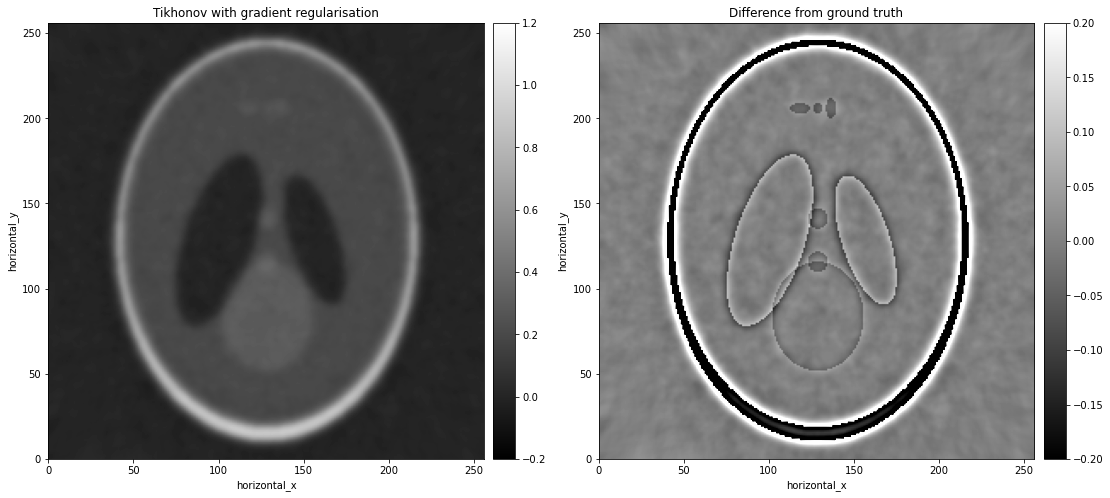

In [40]:
#plot the results
plots = [cgls_tikh_g.solution, cgls_tikh_g.solution - phantom2D]
titles = ["Tikhonov with gradient regularisation","Difference from ground truth" ]
show2D(plots,titles,fix_range=[(-0.2,1.2),(-0.2,0.2)])

Central vertical line profiles of ground truth and Tikhonov with Gradient operator:

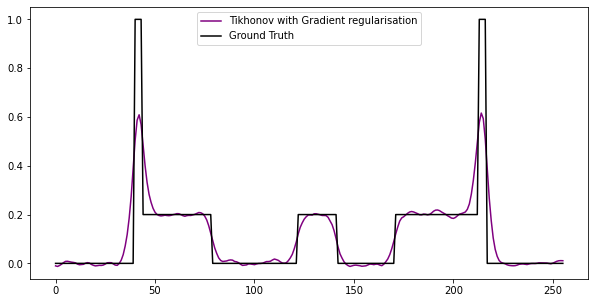

In [41]:
#compare the vertical line profiles
plt.figure(figsize=(10,5))
plt.plot(cgls_tikh_g.solution.get_slice(horizontal_y=n/2).as_array(),label="Tikhonov with Gradient regularisation",color='purple')
plt.plot(phantom2D.get_slice(horizontal_y=n/2).as_array(),label="Ground Truth",color='black')
plt.legend()
plt.show()

### Summary

#### Comparison of the outputs of each reconstruction

To wrap up we compare the reconstructions produced by all reconstruction methods considered in this notebook: Simple CGLS, Tikhonov with Identity regularisation and Tikhonov with Gradient regularisation, along with the ground truth image. We display images and central vertical line profiles:

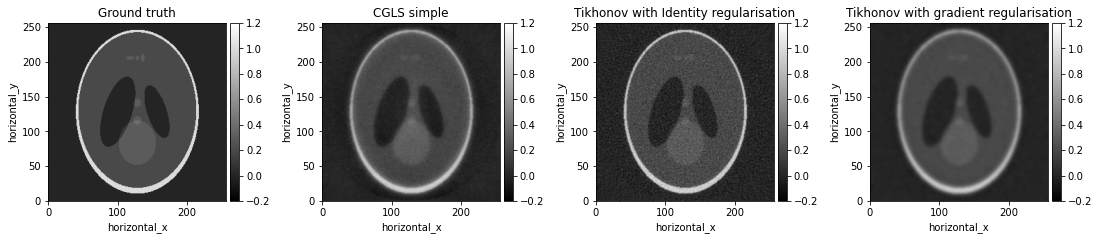

In [42]:
plots = [phantom2D, cgls_simple.solution, cgls_tikh.solution, cgls_tikh_g.solution]
titles = ["Ground truth", "CGLS simple", "Tikhonov with Identity regularisation", "Tikhonov with gradient regularisation" ]
show2D(plots, titles, fix_range=(-0.2,1.2), num_cols=4)

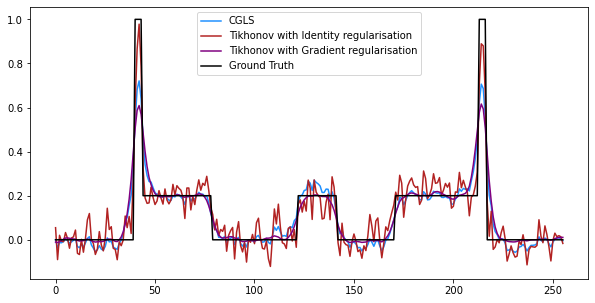

In [43]:
plt.figure(figsize=(10,5))
plt.plot(cgls_simple.solution.get_slice(horizontal_y=n/2).as_array(),label="CGLS",color='dodgerblue')
plt.plot(cgls_tikh.solution.get_slice(horizontal_y=n/2).as_array(),label="Tikhonov with Identity regularisation",color='firebrick')
plt.plot(cgls_tikh_g.solution.get_slice(horizontal_y=n/2).as_array(),label="Tikhonov with Gradient regularisation",color='purple')
plt.plot(phantom2D.get_slice(horizontal_y=n/2).as_array(),label="Ground Truth",color='black')
plt.legend()
plt.show()

As can be seen from images and line profiles, Tikhonov with Gradient regularisation allows us to reduce the noise in the reconstruction substantially. However, we may pay a price in terms of blurring the edges.

**Learning objectives:**

After having worked through this notebook, we have now seen how to:

1. Construct and manipulate BlockOperators and BlockDataContainer, including direct and adjoint operations and algebra.
2. Use Block Framework to solve Tikhonov regularisation with CGLS algorithm.
3. Apply Tikhonov regularisation to tomographic reconstruction and explain the effect of regularisation parameter and operator in regulariser.

This completes the present exercise on Tikhonov regularisation with the CGLS algorithm.  In other exercises we will see how to use the CIL framework for real data reconstruction and how to do regularisation based on non-smooth optimisation, to help preserve edges better, while reducing the noise.